# A5 Convolutional Neural Networks

*my name*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A5-Convolutional-Neural-Networks" data-toc-modified-id="A5-Convolutional-Neural-Networks-1">A5 Convolutional Neural Networks</a></span><ul class="toc-item"><li><span><a href="#Simple-Images" data-toc-modified-id="Simple-Images-1.1">Simple Images</a></span></li><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1.2">Requirements</a></span><ul class="toc-item"><li><span><a href="#Plus,-Minus,-Times,-Divide" data-toc-modified-id="Plus,-Minus,-Times,-Divide-1.2.1">Plus, Minus, Times, Divide</a></span></li><li><span><a href="#Real-Images-from-CIFAR-10" data-toc-modified-id="Real-Images-from-CIFAR-10-1.2.2">Real Images from CIFAR-10</a></span></li></ul></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2">Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3">Extra Credit</a></span></li></ul></div>

For this assignment, use the `ConvNet` class defined for you in Lecture Notes 13.  Cut and paste the contents of the `ConvNet` code cell into a file named `convnet.py`.

In [1]:
%%writefile convnet.py
import numpy as np
import torch
        
class ConvNet(torch.nn.Module):
    
    def __init__(self, input_shape, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs, 
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):
        
        super().__init__()
        
        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers or
            len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')
        
        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu
        
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = input_shape[0]
        input_hw = input_shape[1]  # = input_shape[2]
        self.conv_layers = torch.nn.ModuleList()
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append( torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride) )
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in  # n_hiddens_per_fc_layer[0]
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append( torch.nn.Linear(n_in, nh) )
            n_in = nh

        output_layer = torch.nn.Linear(n_in, n_outputs)
        self.fc_layers.append(output_layer)
        
        output_layer.weight.data[:] = 0.0
        output_layer.bias.data[:] = 0.0

        self.loss_trace = []
        self.accuracy_trace = []
        
        self.to(self.device)


    def _forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append( self.activation_function(conv_layer(Ys[-1])) )

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                flattend_inputs = Ys[-1].reshape(n_samples, -1)
                Ys.append( self.activation_function(fc_layer(flattend_inputs)) )
            else:
                Ys.append( self.activation_function(fc_layer(Ys[-1])) )

        if len(self.fc_layers) == 1:  # no fully connected hidden layers
            flattend_inputs = Ys[-1].reshape(n_samples, -1)
            Ys.append(self.fc_layers[-1](flattend_inputs))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))
        return Ys


    def _forward(self, X):
        Ys = self._forward_all_outputs(X)
        return Ys[-1]
    

    def to_torch(self, M, torch_type=torch.FloatTensor):
        if not isinstance(M, torch.Tensor):
            return torch.from_numpy(M).type(torch_type).to(self.device)
        return M
        
    def percent_correct(self, Y_classes, T):
        if isinstance(T, torch.Tensor):
            T = T.cpu().numpy()
        return (Y_classes == T).mean() * 100
    
    def train(self, Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='sgd', verbose=True,
              Xval=None, Tval=None):
        
        # Assuming Ttrain includes all possible class labels
        self.classes = np.unique(Ttrain)

        # Set data matrices to torch.tensors if not already.

        Xtrain = self.to_torch(Xtrain)
        Ttrain = self.to_torch(Ttrain, torch.LongTensor)
        Xval = self.to_torch(Xval) if Xval is not None else None
        Tval = self.to_torch(Tval, torch.LongTensor) if Tval is not None else None
        
        Xtrain.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        loss_f = torch.nn.CrossEntropyLoss(reduction='mean')
        
        for epoch in range(n_epochs):

            if batch_size == -1:
                num_batches = 1
            else:
                num_batches = Xtrain.shape[0] // batch_size

            loss_sum = 0
            class_train_sum = 0
            
            for k in range(num_batches):
                
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = Xtrain[start:end, ...]
                T_batch = Ttrain[start:end, ...]
                
                Y = self._forward(X_batch)
                
                loss = loss_f(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

                with torch.no_grad():
                    class_train_sum += self.percent_correct(self.use(X_batch)[0], T_batch)
                    
            self.loss_trace.append((loss_sum.item() / num_batches))
            percent_correct_train = class_train_sum / num_batches
            if Xval is not None:
                with torch.no_grad():
                    percent_correct_val = self.percent_correct(self.use(Xval)[0], Tval)
                self.accuracy_trace.append([percent_correct_train, percent_correct_val])
            else:
                self.accuracy_trace.append(percent_correct_train)
                
            if verbose and (epoch + 1) % (n_epochs // 10) == 0:
                print(method, 'Epoch', epoch + 1, 'Loss', self.loss_trace[-1])

        return self


    def _softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y


    def use(self, X):
        # Set input matrix to torch.tensors if not already.
        with torch.no_grad():
            X = self.to_torch(X)
            Y = self._forward(X)
            probs = self._softmax(Y).cpu().numpy()
            classes = self.classes[np.argmax(probs, axis=1)]
            return classes, probs

    def get_loss_trace(self):
        return self.loss_trace

    def get_accuracy_trace(self):
        return self.accuracy_trace


Overwriting convnet.py


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd  # for display and clear_output
import time

import convnet

## Simple Images

Here is a function that generates a simple, fun, data set consisting of four classes of image that we can call `plus`, `minus`, `times` and `divide`.

In [3]:
def make_images(n_each_class):

    n_samples = n_each_class * 4
    
    images = np.zeros((n_samples, 20, 20))  # nSamples, rows, columns
    labels = np.zeros(n_samples)
    label_names = ['plus', 'minus', 'times', 'divide']
    
    radii = 3 + np.random.randint(10 - 5, size=(n_samples, 1))
    centers = np.zeros((n_samples, 2))
    
    for sample_i in range(0, n_samples, 4):
        r = radii[sample_i, 0]
        centers[sample_i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[sample_i, 0])
        y = int(centers[sample_i, 1])
        
        for class_i in range(4):
            
            if class_i == 0:
                # plus
                images[sample_i, x - r:x + r, y] = 1.0
                images[sample_i, x, y - r:y + r] = 1.0
                labels[sample_i] = 0

            elif class_i == 1:
                # minus
                images[sample_i + 1, x, y - r:y + r] = 1.0
                labels[sample_i + 1] = 1

            elif class_i == 2:
                # times
                images[sample_i + 2, range(x - r, x + r), range(y - r, y + r)] = 1.0
                images[sample_i + 2, range(x - r, x + r), range(y + r, y - r, -1)] = 1.0
                labels[sample_i + 2] = 2

            else:  # class_i == 3
                # divide
                images[sample_i + 3, range(x - r, x + r), range(y + r, y - r, -1)] = 1.0
                labels[sample_i + 3] = 3

    n, r, c = images.shape
    images = images.reshape(n, r, c)  # add channel dimension
    return images, labels, label_names

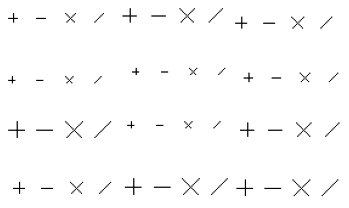

In [4]:
n_each_class = 12

X, T, label_names = make_images(n_each_class)

p = 0
for i in range(X.shape[0]):
    p += 1
    plt.subplot(4, 4 * 3, p)
    plt.imshow(-X[i, :, :], cmap='gray')
    plt.axis('off')

Let's make 500 samples in each class and train our convolutional neural net on this data. Remember to add the channel dimension, of size 1, because we have just one intensity per pixel.  

In [5]:
n_each_class = 500
X, T, label_names = make_images(n_each_class)
X = X.reshape(-1, 1, 20, 20)

We will train on the first 80% of the samples, validate on the next 10% and test on the remaining 10%.

In [6]:
n_samples = X.shape[0]
ntrain = int(n_samples * 0.8)
nval = int(n_samples * 0.1)

Xtrain = X[:ntrain, ...]
Ttrain = T[:ntrain]

Xval = X[ntrain:ntrain + nval, ...]
Tval = T[ntrain:ntrain + nval]
         
Xtest = X[ntrain + nval:, ...]
Ttest = T[ntrain + nval:]

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((1600, 1, 20, 20),
 (1600,),
 (200, 1, 20, 20),
 (200,),
 (200, 1, 20, 20),
 (200,))

In [7]:
input_shape = X.shape[1:]
n_hiddens_per_conv_layer = [5]
patch_size_per_conv_layer = [5]
stride_per_conv_layer = [1]
n_hiddens_per_fc_layer = [10]
n_outputs = 4

batch_size = -1  # means we will not divide training data into batches while training
learning_rate = 0.01
method = 'adam'
n_epochs = 5
n_reps = 50

device = 'cpu'   # or 'cuda'
nnet = convnet.ConvNet(input_shape,
                       n_hiddens_per_conv_layer, 
                       n_hiddens_per_fc_layer,
                       n_outputs,
                       patch_size_per_conv_layer, 
                       stride_per_conv_layer, device=device)

Accuracy Train 100.0 Val 97.5 Test 96.5
Training took 0.51 minutes.


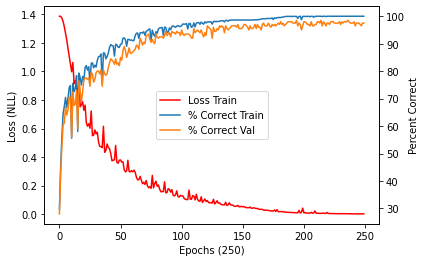

In [8]:
current_length = len(nnet.get_loss_trace())  # in case training existing net again

fig = plt.figure()
start_time = time.time()

for reps in range(n_reps):
    nnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method=method,
            Xval=Xval, Tval=Tval, verbose=False)

    plt.clf()
    ax = fig.add_subplot(111)
    loss_trace = nnet.get_loss_trace()
    plot1 = ax.plot(loss_trace, 'r-')
    ax.set_ylabel('Loss (NLL)')
    ax.set_xlabel('Epochs ({})'.format(current_length + n_reps * n_epochs))

    acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
    acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
    accuracies = nnet.get_accuracy_trace()
    xs = range(0, len(loss_trace), len(loss_trace) // len(accuracies))

    ax2 = ax.twinx()
    plot2 = ax2.plot(xs, accuracies)
    ax2.set_ylabel('Percent Correct')

    plots = plot1 + plot2
    if len(plot2) == 1:
        ax.legend(plots, ('Loss Train', '% Correct Train'), loc='upper center')
    else:
        ax.legend(plots, ('Loss Train', '% Correct Train', '% Correct Val'), loc='center')

    # plt.xlim(0, n_epochs * n_reps)
    
    ipd.clear_output(wait=True)
    ipd.display(fig)
    
ipd.clear_output(wait=True)

acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
acc_val = nnet.percent_correct(nnet.use(Xval)[0], Tval)
acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
print('Accuracy Train', acc_train, 'Val', acc_val, 'Test', acc_test)

print('Training took {:.2f} minutes.'.format((time.time() - start_time)/60.0))

## Requirements

### Plus, Minus, Times, Divide

1. Run all of the above cells.
2. Draw at least 12 `Xtest` images that are correctly classified.  Use `plt.title` to specify the actual and predicted class names, using strings like `'{}\n{}'.format(label_names[Ttest[i]], label_names[Ytest[i]]`.
2. Draw some `Xtest` images that are incorrectly classified.  Again, title each image as you did in step 2.
3. Examine the weights in the first layer.  Draw the weights as images.  Do they make sense, given the kinds of images you are classifying? 
Try changing the network structure and retrain several times to try to make your weight images easier to interpret.

In [9]:
import torch

In [10]:
x = Xtest[30:54]
x = torch.from_numpy(x).float().to(device)
Ys = nnet._forward_all_outputs(x)
x.squeeze().shape

torch.Size([24, 20, 20])

In [11]:
nnet

ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=1280, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=4, bias=True)
  )
)

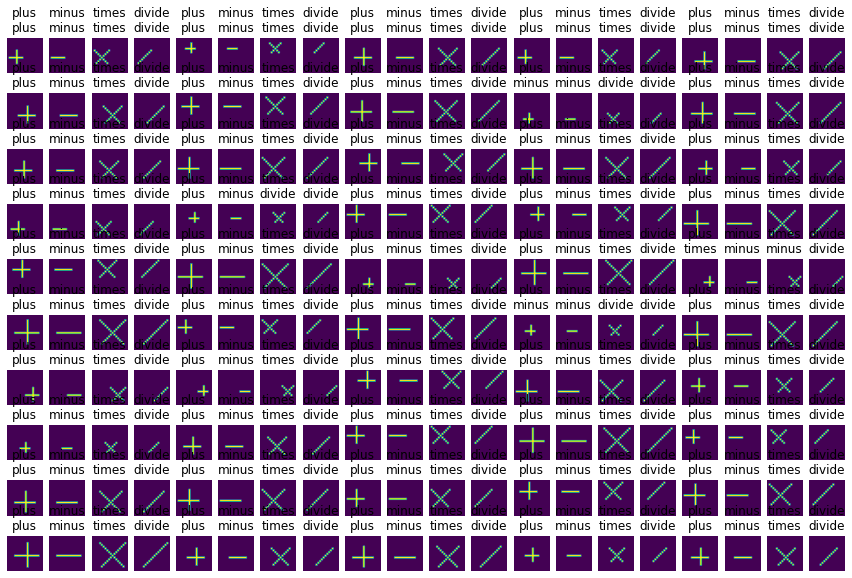

In [12]:
plt.figure(figsize=(15,10))
for i in range(200):
    plt.subplot(10,20,i+1)
    image=Xtest[i,:]
    image=np.moveaxis(image,0,-1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('{}\n{}'.format(label_names[int(Ttest[i])],label_names[int(nnet.use(Xtest[i:i+1])[0])]))  

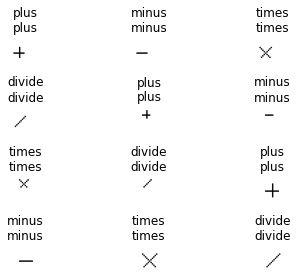

In [13]:
Ytest = nnet.use(Xtest)[0]
c = 0
for i in range (Xtest.shape[0]):
    if Ttest[i] == Ytest[i]:
        c +=1
        if c > 12:
            break
        plt.subplot(4,3,c)
        plt.title('{}\n{}'.format(label_names[int(Ttest[i])], label_names[int(nnet.use(Xtest[i:i+1])[0])]))
        plt.imshow(-Xtest[i,:].reshape(20,20),cmap='gray')
        plt.axis('off')
plt.tight_layout()

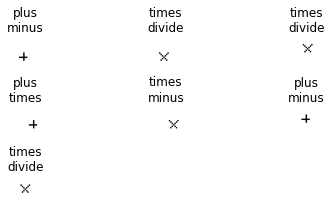

In [15]:
Ytest = nnet.use(Xtest)[0]
w = 0
for i in range (Xtest.shape[0]):
    if Ttest[i] != Ytest[i]:
        w +=1
        if w > 12:
            break
        plt.subplot(4,3,w)
        plt.title('{}\n{}'.format(label_names[int(Ttest[i])], label_names[int(Ytest[i])]))
        plt.imshow(-Xtest[i,:].reshape(20,20),cmap='gray')
        plt.axis('off')
plt.tight_layout()

In [16]:
layer1weights=list(nnet.children())[0][0].weight.data
layer1weights

tensor([[[[-0.2540, -0.2387, -0.1989, -0.0230, -0.0372],
          [ 0.0081,  0.2559,  0.1608,  0.1065, -0.3620],
          [ 0.0296,  0.2411, -0.0816,  0.0974, -0.3021],
          [-0.2837,  0.1583, -0.1862, -0.0487, -0.3295],
          [-0.5856, -0.5408, -0.6904, -0.4724, -0.6229]]],


        [[[-0.3122,  0.1378, -0.3460, -0.0652, -0.2208],
          [ 0.0195, -0.6225, -0.0694,  0.0988, -0.0987],
          [-0.0842, -0.2008, -0.3471,  0.1439, -0.2085],
          [ 0.1641,  0.1449,  0.2345, -0.4564,  0.2036],
          [ 0.1798,  0.0326, -0.3432,  0.0680, -0.3021]]],


        [[[-0.0553, -0.0665,  0.2710,  0.2837,  0.4903],
          [-0.2527, -0.0152,  0.0958,  0.2947,  0.3611],
          [-0.6096, -0.7174, -0.3220, -0.2451, -1.3777],
          [-0.3578, -0.1644,  0.0067, -0.8555, -0.1235],
          [ 0.1210,  0.2554, -0.4058,  0.2874,  0.4218]]],


        [[[-0.1891,  0.0204,  0.0305, -0.5917, -0.1820],
          [ 0.1562, -0.0487, -0.5553,  0.0654,  0.1729],
          [ 0.1782,

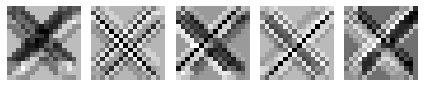

In [17]:
ploti = 0
for i in range(5):
    ploti += 1
    plt.subplot(1, 5, ploti)
    plt.imshow(Ys[1][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')
plt.tight_layout()

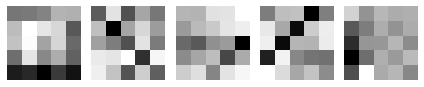

In [18]:
plot1 = 0
for i in range(5):
    plot1 += 1
    plt.subplot(1,5,plot1)
    plt.imshow(nnet.conv_layers[0].weight.data[i].squeeze().cpu(),cmap = 'gray')
    plt.axis('off')
plt.tight_layout()

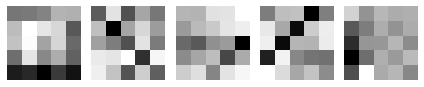

In [19]:
plot1 = 0
for i in range(5):
    plot1 += 1
    plt.subplot(1,5,plot1)
    plt.imshow(nnet.conv_layers[0].weight.data[i].squeeze().cpu(),cmap = 'gray')
    plt.axis('off')
plt.tight_layout()

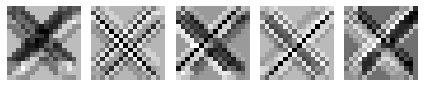

In [20]:
layer2weights = list(nnet.children())[1][0].weight.data

ploti = 0
for i in range(5):
    ploti += 1
    plt.subplot(1, 5, ploti)
    plt.imshow(Ys[1][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')
plt.tight_layout()

In [21]:
layer2weights

tensor([[ 0.3042,  0.1375,  0.2569,  ..., -0.3239, -0.0845, -0.0261],
        [ 0.2250, -0.0601,  0.1831,  ..., -0.1255, -0.3371, -0.0948],
        [-0.2548, -0.2600, -0.2041,  ...,  0.1314, -0.0357, -0.0176],
        ...,
        [ 0.0863,  0.0481,  0.0319,  ...,  0.0162, -0.2661,  0.0132],
        [ 0.1592,  0.2349,  0.2542,  ..., -0.1941, -0.0618, -0.0188],
        [ 0.1420,  0.4299,  0.4575,  ..., -0.0145,  0.0431, -0.1145]])

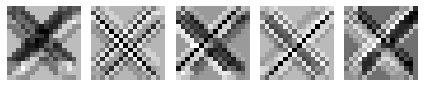

In [22]:
layer3weights = list(nnet.children())[1][1].weight.data

ploti = 0
for i in range(5):
    ploti += 1
    plt.subplot(1, 5, ploti)
    plt.imshow(Ys[1][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')
plt.tight_layout()

In [23]:
layer3weights

tensor([[ 2.0018,  2.0518, -0.5764,  2.1879,  0.5518, -0.6757,  1.5925,  0.7293,
         -1.9197,  0.3791],
        [ 1.6891,  1.8318,  0.7789, -1.9345,  1.8641,  1.1861, -0.3110,  1.9848,
          1.6743, -0.8087],
        [-1.5445, -2.3018,  0.6220,  0.1432, -1.9374,  0.4145,  1.5341, -1.0422,
         -1.9690, -1.0126],
        [-0.9018, -1.9773, -0.6667, -1.7523, -0.4532, -0.5501, -1.9984, -0.8408,
          1.8633,  0.8810]])

### Real Images from CIFAR-10

Download the `CIFAR-10 python version` data from [ Alex Krizhevsky's home page](https://www.cs.toronto.edu/~kriz/cifar.html).  Extract the data from the tar file and read the data using the following code.  We will take the first 5,000 images as training data, the next 5,000 as validation data, and the next 5,000 images as test data.

In [24]:
import pickle

with open('cifar-10-batches-py/batches.meta', 'rb') as f:
     d = pickle.load(f, encoding='bytes')

label_names = [z.decode() for z in d[b'label_names']]

X = []
T = []

for batch in ['data_batch_1', 'data_batch_2']:
    with open('cifar-10-batches-py/' + batch, 'rb') as f:
       d = pickle.load(f, encoding='bytes')

    X_batch = d[b'data']
    T_batch = np.array(d[b'labels'])

    X.append(X_batch)
    T.append(T_batch)
    
X = np.vstack(X)
T = np.hstack(T)

print(X.shape, T.shape)

X = X.reshape(-1, 3, 32, 32)
# T = T.reshape(-1, 1)

n_train = 5000
n_val = 5000
n_test = 5000

first = 0
last = n_train + first
Xtrain = X[first:last, ...]
Ttrain = T[first:last]

first = last
last = last + n_val
Xval = X[first:last, ...]
Tval = T[first:last, ...]

first = last
last = last + n_test
Xtest = X[first:last, ...]
Ttest = T[first:last]

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

(20000, 3072) (20000,)


((5000, 3, 32, 32),
 (5000,),
 (5000, 3, 32, 32),
 (5000,),
 (5000, 3, 32, 32),
 (5000,))

In [25]:
def run_experiment(n_hiddens_per_conv_layer,
                   patch_size_per_conv_layer,
                   stride_per_conv_layer,
                   n_hiddens_per_fc_layer,
                   batch_size,
                   learning_rate,
                   method,
                   n_epochs,
                   n_reps,
                   device):
    
    input_shape = [3, 32, 32]
    n_outputs = 10

    nnet = convnet.ConvNet(input_shape,
                           n_hiddens_per_conv_layer, 
                           n_hiddens_per_fc_layer,
                           n_outputs,
                           patch_size_per_conv_layer, 
                           stride_per_conv_layer, device=device)


    current_length = len(nnet.get_loss_trace())

    fig = plt.figure()
    start_time = time.time()

    for reps in range(n_reps):
        nnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method=method,
                Xval=Xval, Tval=Tval, verbose=False)
        plt.clf()
        ax = fig.add_subplot(111)
        loss_trace = nnet.get_loss_trace()
        plot1 = ax.plot(loss_trace, 'r-')
        ax.set_ylabel('Loss (NLL)')
        ax.set_xlabel('Epochs ({})'.format(current_length + n_reps * n_epochs))

        acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
        acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
        accuracies = nnet.get_accuracy_trace()
        xs = range(0, len(loss_trace), len(loss_trace) // len(accuracies))

        ax2 = ax.twinx()
        plot2 = ax2.plot(xs, accuracies)
        ax2.set_ylabel('Percent Correct')

        plots = plot1 + plot2
        if len(plot2) == 1:
            ax.legend(plots, ('Loss Train', '% Correct Train'), loc='upper center')
        else:
            ax.legend(plots, ('Loss Train', '% Correct Train', '% Correct Val'), 
                      loc='upper center')

        # plt.xlim(0, n_epochs * n_reps)

        ipd.clear_output(wait=True)
        ipd.display(fig)

    ipd.clear_output(wait=True)

    acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
    acc_val = nnet.percent_correct(nnet.use(Xval)[0], Tval)
    acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
    print('Accuracy Train', acc_train, 'Val', acc_val, 'Test', acc_test)

    print('Training took {:.2f} minutes.'.format((time.time() - start_time)/60.0))
    
    return acc_train, acc_val, acc_test, nnet

Accuracy Train 87.4 Val 34.06 Test 34.18
Training took 11.89 minutes.


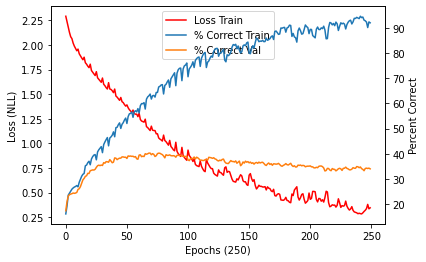

In [26]:
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[10, 10],
    patch_size_per_conv_layer=[5, 5],
    stride_per_conv_layer=[1, 2],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

5. Perform additional experiments with the CIFAR-10 data to investigate these questions:
    1. Do more or fewer layers of convolutional units work better?
    2. How well does a network without convolutional layers work on this data?
    3. Do more or fewer layers of fully-connected units work better?
    4. How well does a network without fully connected layers work on this data?
    3. For what cases do you see overfitting occurring?
6. Examine the weights in the first layer.  Draw the weights as images.  Do they make sense, given the kinds of images you are classifying? 

# 5.A

Accuracy Train 97.44 Val 34.12 Test 33.46
Training took 8.35 minutes.


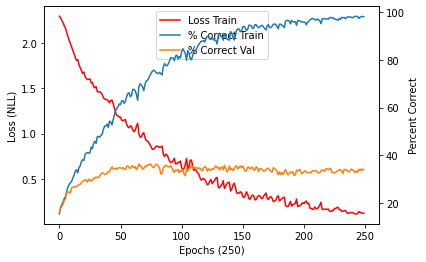

In [27]:
#5.A. Reduce layers of convolutional units

acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[10],
    patch_size_per_conv_layer=[5],
    stride_per_conv_layer=[1],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

Accuracy Train 63.82 Val 39.28 Test 38.0
Training took 12.22 minutes.


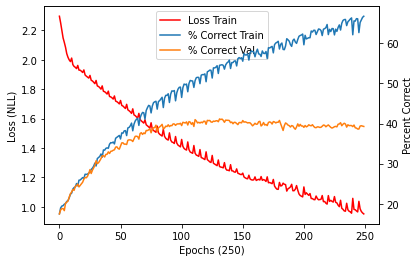

In [28]:
#5.A. Increase layers of convolutional units

acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[10,10,10],
    patch_size_per_conv_layer=[5,5,5],
    stride_per_conv_layer=[1,2,3],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

# 5.B

Accuracy Train 10.38 Val 10.26 Test 10.22
Training took 2.40 minutes.


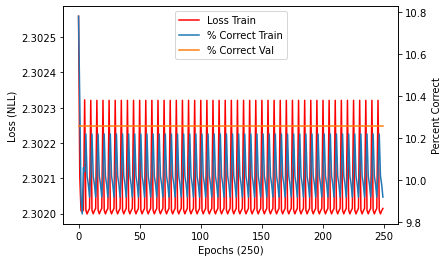

In [29]:
#5.B. Without layers of convolutional units

acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[],
    patch_size_per_conv_layer=[],
    stride_per_conv_layer=[],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

# 5.C

Accuracy Train 10.38 Val 10.26 Test 10.22
Training took 2.29 minutes.


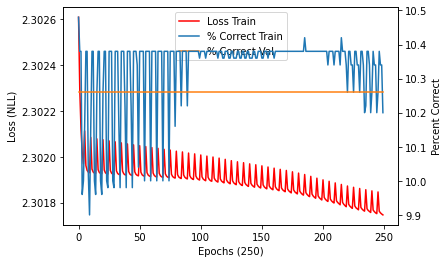

In [30]:
#5.C. More layers of fully-connected units

acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[],
    patch_size_per_conv_layer=[],
    stride_per_conv_layer=[],
    n_hiddens_per_fc_layer=[10,10,10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

Accuracy Train 37.78 Val 23.72 Test 22.720000000000002
Training took 5.79 minutes.


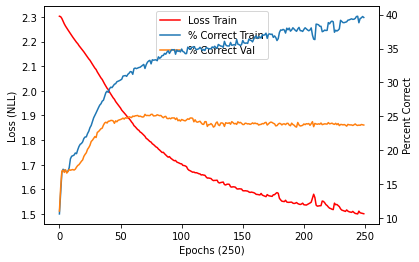

In [31]:
#5.C. Fewer layers of fully-connected units

acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[5,5],
    patch_size_per_conv_layer=[2,2],
    stride_per_conv_layer=[1,2],
    n_hiddens_per_fc_layer=[2],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

# 5.D

Accuracy Train 85.24000000000001 Val 36.620000000000005 Test 37.04
Training took 11.29 minutes.


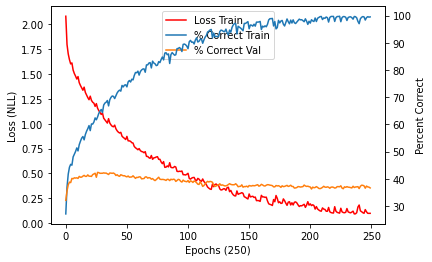

In [32]:
#5.D. Without fully-connected layers

acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[10, 10],
    patch_size_per_conv_layer=[5, 5],
    stride_per_conv_layer=[1, 2],
    n_hiddens_per_fc_layer=[],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cpu')   # or 'cuda'

# 5.E 
By increasing layers of convolutional units the training data and predicted data are almost close and it may therefore fail to fit to additional data or predict future observations reliably.

In [33]:
layer1weights=list(nnet.children())[0][0].weight.data
layer1weights

tensor([[[[-0.0875,  0.0639,  0.0866, -0.0359,  0.0143],
          [ 0.0221,  0.0171, -0.0152,  0.0070,  0.1251],
          [-0.0196,  0.0912,  0.1355, -0.0257,  0.0040],
          [ 0.0076,  0.1185, -0.0086,  0.1204, -0.0506],
          [ 0.0871,  0.0839,  0.0418,  0.1055,  0.0925]],

         [[-0.1791, -0.1521,  0.0546, -0.0395, -0.1193],
          [-0.0301, -0.0393, -0.0187, -0.0266, -0.1427],
          [-0.0455,  0.0037, -0.1005,  0.0915, -0.1250],
          [-0.0026, -0.0114, -0.1136, -0.1394,  0.0512],
          [ 0.0248, -0.0146, -0.0793,  0.0163, -0.0273]],

         [[-0.1057, -0.1176, -0.1034, -0.0118, -0.1035],
          [ 0.1356, -0.0895,  0.0577, -0.0325, -0.0178],
          [ 0.0868, -0.0288,  0.0356,  0.0227, -0.0368],
          [-0.0721, -0.0756, -0.0582, -0.0108, -0.1116],
          [-0.0523, -0.0725, -0.0111,  0.0274,  0.0123]]],


        [[[-0.0482,  0.0752,  0.0479,  0.0232,  0.0602],
          [-0.0086,  0.0023, -0.1128, -0.0190, -0.1332],
          [ 0.1284,  0.

/var/folders/cy/xqvbtsps4c554p7w04g2ywb00000gn/T/ipykernel_29896/2679320218.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646981653/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  plt.imshow(nnet.conv_layers[0].weight.data[i].T.squeeze().cpu()*255)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [

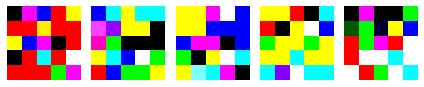

In [34]:
plotthree = 0
for i in range(5):
    plotthree += 1
    plt.subplot(1,5,plotthree)
    plt.imshow(nnet.conv_layers[0].weight.data[i].T.squeeze().cpu()*255)
    plt.axis('off')
plt.tight_layout()

# Grading

No grading script will be provided for this assignment.  Your grade will be based on how well you answer the stated questions.

# Extra Credit

Try using all of the CIFAR-10 data, meaning all six batches of data. Train and test your network on a GPU.  Report results, including training time.